In [11]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from utils.narxwithga import NARXModel  # Assuming this will be updated too
import random
from utils.ga import GeneticAlgorithm
import joblib

# Set seeds for reproducibility
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

# Load and clean data
df = pd.read_csv('data/train_data.csv')
df = df.dropna().reset_index(drop=True)

# Set delays
input_delay = 4
output_delay = 4

columns = ['0.30','0.50','0.75','0.90','0.95','f']

def extract_states(row):
    """
    Given a DataFrame row, returns a (T,6) array of states:
    [t0, t1, t2, t3, x, y] for each percentage in col_perc order.
    """
    states = []
    for p in columns:
        t0 = row[f't0{p}']
        t1 = row[f't1{p}']
        t2 = row[f't2{p}']
        t3 = row[f't3{p}']
        x  = row[f'x{p}']
        y  = row[f'y{p}']
        states.append([t0, t1, t2, t3, x, y])
    return np.array(states)

def prepare_narx_data(df, n_y, n_u=None):
    """
    Builds NARX dataset from multi-step trajectory rows.
    Returns X of shape (N_samples, 4 + 2*n_y + 4*n_u) and Y of shape (N_samples, 2).
    """
    if n_u is None:
        n_u = n_y  # default: same number of delayed inputs and outputs
    
    X_list, Y_list = [], []
    for _, row in df.iterrows():
        states = extract_states(row)    # (T,6)
        angles = states[:, :4]          # (T,4)
        coords = states[:, 4:6]         # (T,2)
        for t in range(max(n_y, n_u), len(states)):
            delayed_coords = coords[t - n_y:t].flatten()  # (2 * n_y,)
            delayed_angles = angles[t - n_u:t].flatten()  # (4 * n_u,)
            x_t = np.concatenate([angles[t], delayed_coords, delayed_angles])
            y_t = coords[t]
            X_list.append(x_t)
            Y_list.append(y_t)
    return np.array(X_list), np.array(Y_list)

# Prepare raw input and output
X_raw = df[['t0', 't1', 't2', 't3']].values 
Y_raw = df[['xc', 'yc']].values  

# Build NARX-style delayed inputs
X_new = []
Y_new = []

for t in range(max(input_delay, output_delay), len(X_raw)):
    # Stack past input_delay steps in reverse order (t-1, t-2, ..., t-input_delay)
    delayed_inputs = np.concatenate([X_raw[t - i - 1] for i in range(input_delay)])
    delayed_outputs = np.concatenate([Y_raw[t - i - 1] for i in range(output_delay)])
    
    # No current input to avoid leakage
    combined_input = np.concatenate([delayed_inputs, delayed_outputs])
    
    X_new.append(combined_input)
    Y_new.append(Y_raw[t])

X_new = np.array(X_new)
Y_new = np.array(Y_new)

# Train/test split
X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y_new, test_size=0.25, random_state=42)

# Normalize inputs/outputs
input_scaler = StandardScaler()
X_train_norm = input_scaler.fit_transform(X_train)
X_test_norm = input_scaler.transform(X_test)

output_scaler = StandardScaler()
Y_train_norm = output_scaler.fit_transform(Y_train)
Y_test_norm = output_scaler.transform(Y_test)

np.save('data/X_test_norm.npy', X_test_norm)
np.save('data/Y_test_norm.npy', Y_test_norm)
np.save('data/Y_test.npy', Y_test)
joblib.dump(output_scaler, 'models/output_scaler.pkl')
joblib.dump(input_scaler, 'models/input_scaler.pkl')


# Convert to PyTorch tensors
X_tensor = torch.tensor(X_train_norm, dtype=torch.float32)
Y_tensor = torch.tensor(Y_train_norm, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_norm, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test_norm, dtype=torch.float32)

# Determine input dimension
input_dim = (input_delay * X_raw.shape[1]) + (output_delay * Y_raw.shape[1])


In [30]:


# Run Genetic Algorithm
ga = GeneticAlgorithm(
    population_size=100,
    mutation_rate=0.5,
    crossover_rate=0.5,
    input_dim=input_dim,
    X_tensor=X_tensor,
    Y_tensor=Y_tensor
)

best_model = ga.run(generations=1000)
torch.save(best_model.state_dict(), 'models/best_ga_model.pth')

with torch.no_grad():
    predictions = best_model(X_test_tensor).numpy()
    predictions_original = output_scaler.inverse_transform(predictions)
    Y_test_original = output_scaler.inverse_transform(Y_test_norm)

    preds_train_norm = best_model(X_tensor).numpy()
    preds_train = output_scaler.inverse_transform(preds_train_norm)
    Y_train_true = output_scaler.inverse_transform(Y_tensor.numpy())

# Evaluation
print("\nTrain set performance:")
print(f"MSE : {mean_squared_error(Y_train_true, preds_train):.5f}")
print(f"RMSE: {np.sqrt(mean_squared_error(Y_train_true, preds_train)):.5f}")
print(f"MAE : {mean_absolute_error(Y_train_true, preds_train):.5f}")
print(f"R^2 : {r2_score(Y_train_true, preds_train):.5f}")

print("\nEvaluation Metrics on Test Data:")
print(f"MSE : {mean_squared_error(Y_test_original, predictions_original):.5f}")
print(f"RMSE: {np.sqrt(mean_squared_error(Y_test_original, predictions_original)):.5f}")
print(f"MAE : {mean_absolute_error(Y_test_original, predictions_original):.5f}")
print(f"R^2 : {r2_score(Y_test_original, predictions_original):.5f}")


Generation 1, Best Fitness (MSE): 0.99516
Generation 2, Best Fitness (MSE): 0.85198
Generation 3, Best Fitness (MSE): 0.85198
Generation 4, Best Fitness (MSE): 0.85198
Generation 5, Best Fitness (MSE): 0.82404
Generation 6, Best Fitness (MSE): 0.62182
Generation 7, Best Fitness (MSE): 0.62182
Generation 8, Best Fitness (MSE): 0.56121
Generation 9, Best Fitness (MSE): 0.56121
Generation 10, Best Fitness (MSE): 0.56121
Generation 11, Best Fitness (MSE): 0.56121
Generation 12, Best Fitness (MSE): 0.56121
Generation 13, Best Fitness (MSE): 0.56121
Generation 14, Best Fitness (MSE): 0.56121
Generation 15, Best Fitness (MSE): 0.55766
Generation 16, Best Fitness (MSE): 0.49598
Generation 17, Best Fitness (MSE): 0.49598
Generation 18, Best Fitness (MSE): 0.47730
Generation 19, Best Fitness (MSE): 0.47730
Generation 20, Best Fitness (MSE): 0.44199
Generation 21, Best Fitness (MSE): 0.44199
Generation 22, Best Fitness (MSE): 0.44199
Generation 23, Best Fitness (MSE): 0.43247
Generation 24, Best 

In [6]:
import torch
import numpy as np
import random
import joblib
import pandas as pd
from utils.narxwithga import NARXModel

# Load saved assets
X_test_norm = np.load("data/X_test_norm.npy")
Y_test_norm = np.load("data/Y_test_norm.npy")   # normalized
Y_test = np.load("data/Y_test.npy")             # unnormalized
output_scaler = joblib.load("models/output_scaler.pkl")
input_scaler = joblib.load("models/input_scaler.pkl")
input_dim = X_test_norm.shape[1]

# Load model
model = NARXModel(input_dim=input_dim, output_dim=2)
model.load_state_dict(torch.load("models/best_ga_model.pth"))
model.eval()

# Choose a random test index
rand_test_index = random.randint(0, len(X_test_norm) - 1)

# Prepare input tensor
input_tensor = torch.tensor(X_test_norm[rand_test_index:rand_test_index+1], dtype=torch.float32)
true_output = Y_test[rand_test_index]  # already unnormalized

# Predict
with torch.no_grad():
    pred_scaled = model(input_tensor).numpy()
    pred_original = output_scaler.inverse_transform(pred_scaled)

# Print prediction vs ground truth
print("\n--- Random Test Sample Evaluation ---")
print(f"Random Test Index: {rand_test_index}")
print(f"Predicted (x, y): {pred_original[0]}")
print(f"Ground Truth (x, y): {true_output}")



--- Random Test Sample Evaluation ---
Random Test Index: 1
Predicted (x, y): [4.512075  1.4545293]
Ground Truth (x, y): [4.626 1.26 ]


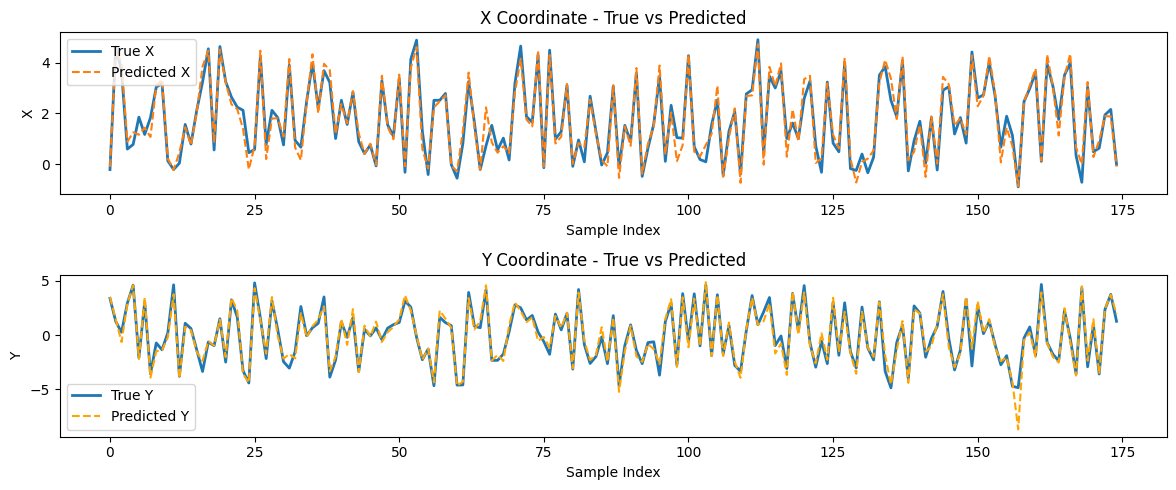

In [12]:
X_test_tensor = torch.tensor(X_test_norm, dtype=torch.float32)
with torch.no_grad():
    all_preds_scaled = model(X_test_tensor).numpy()
    all_preds = output_scaler.inverse_transform(all_preds_scaled)

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(2, 1, 1)
plt.plot(Y_test[:, 0], label='True X', linewidth=2)
plt.plot(all_preds[:, 0], label='Predicted X', linestyle='--')
plt.title('X Coordinate - True vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('X')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(Y_test[:, 1], label='True Y', linewidth=2)
plt.plot(all_preds[:, 1], label='Predicted Y', linestyle='--', color='orange')
plt.title('Y Coordinate - True vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Y')
plt.legend()

plt.tight_layout()
plt.show()


In [23]:
import torch
import numpy as np
import joblib
from utils.narxwithga import NARXModel
import pandas as pd

# === Load scalers and model ===
input_scaler = joblib.load("models/input_scaler.pkl")
output_scaler = joblib.load("models/output_scaler.pkl")
X_test_norm = np.load("data/X_test_norm.npy")
input_dim = X_test_norm.shape[1]

model = NARXModel(input_dim=input_dim, output_dim=2)
model.load_state_dict(torch.load("models/best_ga_model.pth"))
model.eval()

# === Config ===
input_delay = 4
output_delay = 4
angle_dim = 4
coord_dim = 2
print("==== NARX Prediction from User Input ====")
print(f"Assuming input_delay={input_delay}, output_delay={output_delay}")
print("Initial histories filled with zeros.\n")

df = pd.read_csv("data/train_data.csv").dropna()

columns = ['0.30','0.50','0.75','0.90','0.95','f']

def extract_states(row):
    """
    Given a DataFrame row, returns a (T,6) array of states:
    [t0, t1, t2, t3, x, y] for each percentage in col_perc order.
    """
    states = []
    for p in columns:
        t0 = row[f't0{p}']
        t1 = row[f't1{p}']
        t2 = row[f't2{p}']
        t3 = row[f't3{p}']
        x  = row[f'x{p}']
        y  = row[f'y{p}']
        states.append([t0, t1, t2, t3, x, y])
    return np.array(states)


angles = df[['t0', 't1', 't2', 't3']].values
coords = df[['xc', 'yc']].values

# Use first `input_delay` and `output_delay` for delayed histories
delayed_inputs = angles[:input_delay]     # shape: (4, 4)
delayed_outputs = coords[:output_delay]   # shape: (4, 2)

def run_narx(input_angles):
    while True:
        try:            
            angles = np.array(input_angles)
            if len(angles) != angle_dim:
                raise ValueError("Please enter exactly 4 joint angles.")

            # Shift histories
            delayed_inputs = np.roll(delayed_inputs, shift=-1, axis=0)
            delayed_outputs = np.roll(delayed_outputs, shift=-1, axis=0)

            # Update current input (most recent)
            delayed_inputs[-1] = angles

            # Construct full NARX-style input: [current, output history, input history]
            # Flatten: [current_input, delayed_outputs, delayed_inputs]
            current_input = angles
            flat_outputs = delayed_outputs.flatten()
            flat_inputs = delayed_inputs.flatten()
            narx_input = np.concatenate([current_input, flat_outputs, flat_inputs])

            # Pad if necessary (for first few steps)
            if narx_input.shape[0] < input_dim:
                padding = np.zeros(input_dim - narx_input.shape[0])
                narx_input = np.concatenate([narx_input, padding])

            # Scale and predict
            narx_input_scaled = input_scaler.transform([narx_input])
            input_tensor = torch.tensor(narx_input_scaled, dtype=torch.float32)

            with torch.no_grad():
                pred_scaled = model(input_tensor).numpy()
                pred_original = output_scaler.inverse_transform(pred_scaled)

            # Save output to history
            delayed_outputs[-1] = pred_original[0]

            print(f"✅ Predicted (x, y): {pred_original[0]}\n")
            print(f"four coordinates of the last 4 steps: {delayed_outputs.flatten()}")

        except Exception as e:
            print(f"⚠️ Error: {e}\n")


==== NARX Prediction from User Input ====
Assuming input_delay=4, output_delay=4
Initial histories filled with zeros.



In [16]:
import torch
import torch.nn as nn
import numpy as np

# Define a RNN simples
class ControlRNN(nn.Module):
    def __init__(self, input_size=4, hidden_size=32, num_layers=1, activation='tanh', dropout_rate=0):
        super(ControlRNN, self).__init__()
        # recebe as quatro últimas posições e dá a próxima posição como saída
        self.input_size = input_size + 2
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, 
                          nonlinearity=activation, dropout=dropout_rate, 
                          batch_first=True)
        # recebe a próxima posição [x, y] e dá os thetas como saída
        #self.dropout = nn.Dropout(p=drop_rate)
        self.fc = nn.Linear(hidden_size, input_size)

    def forward(self, x, goal):
        goal_repeated = goal.unsqueeze(1).repeat(1, x.shape[1], 1)

        x = torch.cat([x, goal_repeated], dim=2)

        pos, _ = self.rnn(x)
        new_pos = pos[:, -1, :]  # pegamos só a última saída
        thetas = self.fc(new_pos)
        return thetas

def train_net(model, tloader, vloader, num_epochs, optimizer, lossFunc=nn.MSELoss(), delta=None, patience=None, verbose=2, alpha=1.0):
    train_losses = []
    test_losses = []
    best_train_score = None
    best_val_score = None
    for e in range(num_epochs):
        train_loss = 0.0 # total loss during single epoch training
        val_loss = 0.0
        model.train()
        for X_batch, goal_batch, y_batch, target_pos_batch in tloader:
            #X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
            pred_thetas = model(X_batch, goal_batch)
            pred_pos = run_narx(pred_thetas)
            loss_theta = lossFunc(pred_thetas, y_batch)  # calculates the loss function result
            loss_goal = lossFunc(pred_pos, target_pos_batch)  # calculates the loss function result
            
            total_loss = loss_theta + alpha * loss_goal
            
            
            optimizer.zero_grad() # clears x.grad for every parameter x in the optimizer.
            total_loss.backward() # computes dloss/dx for every parameter x which has requires_grad=True. These are accumulated into x.grad for every parameter x
            optimizer.step() # updates the value of x using the gradient x.grad

            train_loss += np.sqrt(total_loss.item())

        model.eval()
        with torch.no_grad():
            for X_batch, goal_batch, y_batch, target_pos_batch in vloader:
                #X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
                pred_thetas = model(X_batch, goal_batch)
                pred_pos = run_narx(pred_thetas)
                loss_theta = lossFunc(pred_thetas, y_batch)
                loss_goal = lossFunc(pred_pos, target_pos_batch)
                total_loss = loss_theta + alpha * loss_goal
                val_loss += np.sqrt(total_loss.item())

            avg_train_loss = train_loss / len(tloader)
            avg_val_loss = val_loss / len(vloader)
            if(verbose >= 1):
                print(f'Epoch [{e + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Eval Loss: {avg_val_loss:.4f}')
        train_losses.append(avg_train_loss)
        test_losses.append(avg_val_loss)

        # Armazenamento do melhor modelo com base no score de validação
        if((best_val_score is None) or (best_val_score > avg_val_loss)):
                    best_val_score = avg_val_loss
                    best_e = e
                    best_model = model
                    if(verbose >= 2):
                        print('best_model updated')

        # Early stopping com base no score de treinamento (não foi usado mas enf)
        if((delta is not None) and (patience is not None)):
            if((best_train_score is None) or (best_train_score-avg_train_loss >= delta)):
                counter = 0
                best_train_score = avg_train_loss
            else:
                counter += 1
                if(counter>=patience):
                    if(verbose >= 2):
                        print("Early Stopping!")
                    break

    return best_model, best_e, (train_losses, test_losses)

In [13]:
from utils.runnarx import run_narx
import torch

input_tensor = torch.tensor([0, 3, 4, 5], dtype=torch.float32)
run_narx(input_tensor)

tensor([[ 4.8368,  0.7402],
        [ 4.0675, -1.6280],
        [ 4.0224,  2.5317],
        [ 3.4738,  3.7383]])

In [17]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

df = pd.read_csv("data/narx_train_dataset.csv").dropna()

# Positions to use as inputs (4 steps)
perc_steps = ["0.30", "0.50", "0.75", "0.90"]

input_seqs = []
goal_coords = []
target_thetas = []
target_positions = []

for _, row in df.iterrows():
    pos_seq = []
    for p in perc_steps:
        x = row[f"x{p}"]
        y = row[f"y{p}"]
        pos_seq.append([x, y])
    
    # Final goal
    xf, yf = row["xf"], row["yf"]
    
    # Final joint angles and optional fifth joint (use 0 or compute from path length if needed)
    theta_out = [row["t0f"], row["t1f"], row["t2f"], row["t3f"]]
    
    input_seqs.append(pos_seq)
    goal_coords.append([xf, yf])
    target_thetas.append(theta_out)
    target_positions.append([xf, yf])

# Convert to tensors
input_seqs = torch.tensor(input_seqs, dtype=torch.float32)
goal_coords = torch.tensor(goal_coords, dtype=torch.float32)   
target_thetas = torch.tensor(target_thetas, dtype=torch.float32)
target_positions = torch.tensor(target_positions, dtype=torch.float32)

# Split
X_train, X_test, G_train, G_test, y_train, y_test, P_train, P_test = train_test_split(
    input_seqs, goal_coords, target_thetas, target_positions, test_size=0.2, random_state=42)

BATCH_SIZE = 8

train_loader = DataLoader(TensorDataset(X_train, G_train, y_train, P_train), batch_size=BATCH_SIZE)
test_loader = DataLoader(TensorDataset(X_test, G_test, y_test, P_test), batch_size=BATCH_SIZE)

# Dados de exemplo
# Suponha batch_size = 1, seq_len = 4, input_size = 2 (x, y)
from itertools import product
from utils.rnn import ControlRNN, train_net
from utils.runnarx import run_narx
import torch
import torch.nn as nn

# Inicializa a RNN
model = ControlRNN(input_size=4)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0005)


hidden_size = [100]
num_layers = [50]
dropout_rate = [0]
learning_rate = [0.0001]
weight_decay = [0.0005]
activation = ['relu']
optimizer = ['adam']
best_model = None
best_score = None

params_grid = product(hidden_size, num_layers, activation, dropout_rate, learning_rate, weight_decay, optimizer)

for hs, nl, a, dr, lr, wd, o in params_grid:
    if(not((dr>0) and (nl==1))):
        model = ControlRNN(input_size=4, hidden_size=hs, 
                        num_layers=nl,
                        activation=a, dropout_rate=dr)
        if(o=='adam'):
            opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
        else:
            opt = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
        
        
        model, _, scores = train_net(model, train_loader, test_loader, 25, opt, verbose=1, alpha=0.1)
        score = np.mean(scores[1])
        
        if(best_score is None or best_score > score):
            print('[Melhor modelo atualizado]')
            print('hs:{}, nl:{}, dr:{}, lr:{}, a:{}, o:{}, wd:{}'.format(hs, nl, dr, lr, a, o, wd))
            best_model = model
            best_score = score                  

# Teste
input_data = (input_seqs, goal_coords)
predicted = best_model(*input_data).detach()
print("Predição:", predicted)

==== NARX Prediction from User Input ====
Assuming input_delay=4, output_delay=4
Initial histories filled with zeros.



c:\Users\Jessy\Videos\mlp-robot\utils\runnarx.py:94: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  return torch.tensor(preds, dtype=torch.float32)


Epoch [1/25], Train Loss: 98.5899, Eval Loss: 98.4969
Epoch [2/25], Train Loss: 80.3168, Eval Loss: 60.2023
Epoch [3/25], Train Loss: 58.7957, Eval Loss: 56.8596
Epoch [4/25], Train Loss: 58.8213, Eval Loss: 56.6570
Epoch [5/25], Train Loss: 58.8205, Eval Loss: 56.5745
Epoch [6/25], Train Loss: 58.8288, Eval Loss: 56.5336
Epoch [7/25], Train Loss: 58.8294, Eval Loss: 56.5004


KeyboardInterrupt: 

In [7]:
best_model

ControlRNN(
  (rnn): RNN(4, 100, num_layers=50, batch_first=True)
  (fc): Linear(in_features=100, out_features=4, bias=True)
)

In [8]:
#with open(, 'wb') as f:
best_model.eval()
torch.save(best_model.state_dict(), 'models/nn_model.pt')

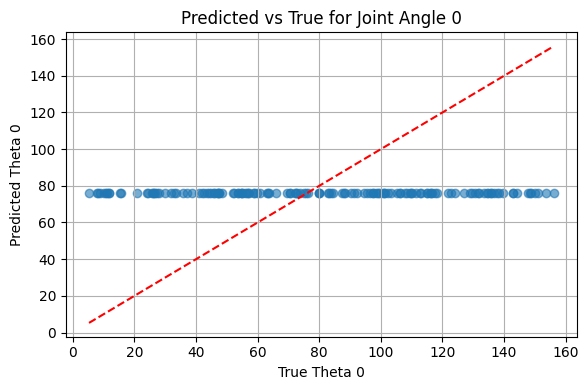

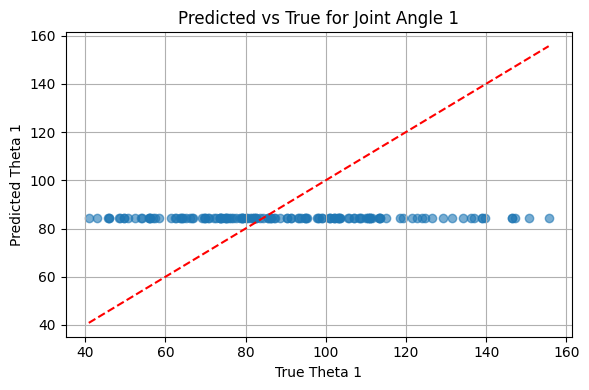

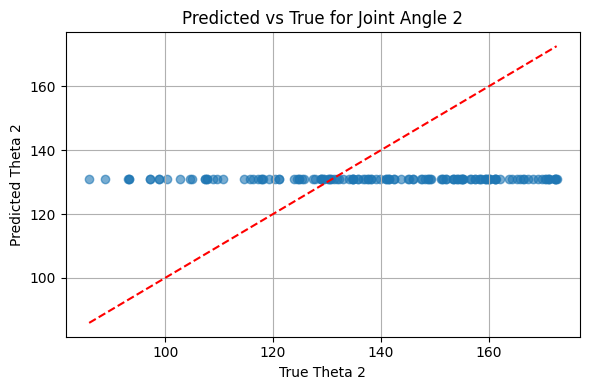

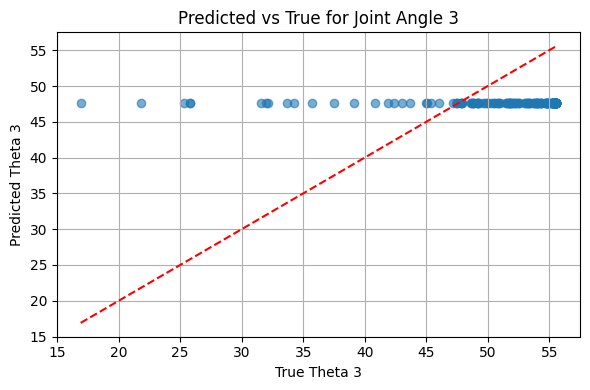

In [10]:
import matplotlib.pyplot as plt

# Run model on test set
best_model.eval()
with torch.no_grad():
    predictions = best_model(X_test, G_test)

# Plot each joint angle
for i in range(predictions.shape[1]):
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test[:, i].numpy(), predictions[:, i].numpy(), alpha=0.6)
    plt.plot([y_test[:, i].min(), y_test[:, i].max()], 
             [y_test[:, i].min(), y_test[:, i].max()], 'r--')
    plt.xlabel(f'True Theta {i}')
    plt.ylabel(f'Predicted Theta {i}')
    plt.title(f'Predicted vs True for Joint Angle {i}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
